# Correlação entre centralidade in-degre e score de sentimento de entidades de rede de mídia social

## Coleta e tratamento de dados

Para conseguir acesso a API do twitter para coleta de posts, é necessário seguir os passos conforme o site: https://developer.twitter.com/en/docs/basics/authentication/guides/access-tokens.html

In [ ]:
# Configurando a autenticação do pacote tweepy

# Carregando os pacotes necessários
from tweepy import OAuthHandler
from tweepy import API

# Autenticação da "consumer key"
consumer_key = "VGldO5N270dm4SBtiLSWi6UbM"
consumer_secret = "znpo5UgRmKqt9R1UuN2MonIw5TOkEVtvpuuZVSLvvwpRRhs9G0" 
auth = OAuthHandler(consumer_key, consumer_secret)

# Autenticação da "access key" 
access_token = "1087340053892919296-Ik0uNn63oStHrfQ8YUHoKAd5HanpUX"
access_token_secret = "VNzCDSqxD3nYdNUoLbIwPvJCOnBMZQwDBfmB8OufVFxZ1"
auth.set_access_token(access_token, access_token_secret)

# Configurando a API com a autenticação
api = API(auth)

In [ ]:
# Definindo as palavras ou hashtags que serão rastreadas
keywords_to_track = ['Trump']

In [ ]:
# Coletando posts do twitter através da API

from tweepy import Stream
from tweepy import StreamListener
import json
import time
import os
import sys

path = '/packages/Lib/site-packages'
sys.path.insert(0, os.getcwd() + path)

# Criando o SListener
class SListener(StreamListener):
    def __init__(self, api = None, fprefix = 'streamer'):
        self.api = api or API()
        self.counter = 0
        self.fprefix = fprefix
        self.output  = open('%s_%s.json' % (self.fprefix, time.strftime('%Y%m%d-%H%M%S')), 'w')

    def on_data(self, data):
        if 'in_reply_to_status' in data:
            self.on_status(data)
        elif 'delete' in data:
            delete = json.loads(data)['delete']['status']
            if self.on_delete(delete['id'], delete['user_id']) is False:
                return False
        elif 'limit' in data:
            if self.on_limit(json.loads(data)['limit']['track']) is False:
                return False
        elif 'warning' in data:
            warning = json.loads(data)['warnings']
            print("WARNING: %s" % warning['message'])
            return

    def on_status(self, status):
        self.output.write(status)
        self.counter += 1
        if self.counter >= 20000 # define quantos posts serão coletados, no caso são 20.000 posts
            self.output.close()
            self.output  = open('%s_%s.json' % (self.fprefix, time.strftime('%Y%m%d-%H%M%S')), 'w')
            self.counter = 0
        return

    def on_delete(self, status_id, user_id):
        print("Delete notice")
        return

    def on_limit(self, track):
        print("WARNING: Limitation notice received, tweets missed: %d" % track)
        return

    def on_error(self, status_code):
        print('Encountered error with status code:', status_code)
        return 

    def on_timeout(self):
        print("Timeout, sleeping for 60 seconds...")
        time.sleep(60)
        return 

# Criando uma instância para o SListener 
listen = SListener(api, 'Trump') # Inclui a palavra Trump no nome do arquivo

# Criando uma instância para Stream
stream = Stream(auth, listen)

# Coletando os posts do twitter!
print('A coleta dos posts começou! Obs: para pausar a coleta de posts do twitter através do stream, vá na aba "Files" do jupyter notebook, selecione o arquivo do jupyter notebook e clique em "Shutdown", isso é necessário para os códigos adiante funcionarem!')
stream.filter(track = keywords_to_track, languages=['en']) # o argumento "languages" define a língua dos posts que serão coletados no twitter

In [1]:
# Carregando os pacotes para a transformação do arquivo .json para data frame do pandas
import pandas as pd
import numpy as np

# Carregando o arquivo .json com os posts do twitter
file = open('Trump_20190126-160219.json', 'r', encoding = 'utf-8') # no primeiro argumento inserir o arquivo, ex: 'file.json'
tweets_json = file.read().split("\n")

# Removendo linhas vazias
tweets_json = list(filter(len, tweets_json))

In [2]:
# Objeto que irá armazenar todos os posts do twitter 
tweets = []

# Carregando pacote para ler os arquivos .json
import json

# Iterando através de cada tweet
for tweet in tweets_json:
    try:
        tweet_obj = json.loads(tweet)
    
        # Armazenando o nome do usuário
        tweet_obj['user-screen_name'] = tweet_obj['user']['screen_name']
    
        # Armazenando o nome do usuário que fez retweet e armazenando o texto do retweet
        if 'retweeted_status' in tweet_obj:
            tweet_obj['retweeted_status-user-screen_name'] = tweet_obj['retweeted_status']['user']['screen_name']
            tweet_obj['retweeted_status-text'] = tweet_obj['retweeted_status']['text']
        
        # Armazenando citações
        if 'quoted_status' in tweet_obj:
            tweet_obj['quoted_status-text'] = tweet_obj['quoted_status']['text'] 
            tweet_obj['quoted_status-user-screen_name'] = tweet_obj['quoted_status']['user']['screen_name']
    
        tweets.append(tweet_obj)
    except:
        pass

In [4]:
# Criando o data frame com pandas!
df_tweet = pd.DataFrame(tweets)

# Análise de sentimento das postagens

A análise de sentimento é uma ferramenta de classificação de texto que analisa as palavras e retorna um sentimento positivo, negativo ou neutro. 

In [5]:
# Carregando o pacote SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Criando uma instância para a função SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
# Gerando scores de sentimento dos influenciadores (feature: retweeted_status-text)
df_tweet['retweeted_status-text'] = df_tweet['retweeted_status-text'].astype(str) # isso é necessário para reparar um erro de tipagem
target_sentiment = df_tweet['retweeted_status-text'].apply(sid.polarity_scores)

# Incluindo os scores de sentimento dos influenciadores no data frame
target_s = []
for index, i in enumerate(target_sentiment):
    target_s.append(target_sentiment[index].get('compound'))

df_tweet['target_sentiment'] = target_s

In [7]:
# Frequência de posts positivos e negativos dos influenciadores
print("Posts positivos:" + str(sum(df_tweet['target_sentiment'] > 0.6)))
print("Posts negativos:" + str(sum(df_tweet['target_sentiment'] < -0.6)))

Posts positivos:1014
Posts negativos:1643


In [8]:
# Gerando scores de sentimento dos influenciados (feature: text) 
source_sentiment = df_tweet['text'].apply(sid.polarity_scores)

# Incluindo os scores de sentimento dos influenciados no data frame
source_s = []
for index, i in enumerate(source_sentiment):
    source_s.append(source_sentiment[index].get('compound'))

df_tweet['source_sentiment'] = source_s

In [9]:
# Frequência de posts positivos e negativos dos influenciados
print("Posts positivos:" + str(sum(df_tweet['source_sentiment'] > 0.6)))
print("Posts negativos:" + str(sum(df_tweet['source_sentiment'] < -0.6)))

Posts positivos:1441
Posts negativos:2193


# Análise de rede

### Criando a rede de retweets

A mídia social é por natureza uma rede. As redes do Twitter se manifestam de várias maneiras, um dos tipos mais importantes de redes que aparecem no Twitter são as redes de retweets. Podemos representá-los como gráficos direcionados, com o usuário retweetando como a fonte e a pessoa retweetada como o alvo.

In [10]:
# Carregando o pacote networkx
import networkx as nx

# Criando a rede de retweets a partir da edgelist do data frame
G_rt = nx.from_pandas_edgelist(
    df_tweet,
    source = 'user-screen_name', 
    target = 'retweeted_status-user-screen_name',
    create_using = nx.DiGraph())
    
# Visualizando o número de nós
print('Nós:', len(G_rt.nodes()))

# Visualizando o número de arestas
print('Arestas:', len(G_rt.edges()))

Nós: 15725
Arestas: 18685


### Visualizando a rede de retweets

A visualização de redes de retweets é uma importante etapa da análise exploratória de dados pois nos permite inspecionar visualmente a estrutura da rede, entender se existe algum usuário que tenha influência desproporcional e se há diferentes esferas de conversação.

In [ ]:
import matplotlib.pyplot as plt

# Instância de tamanho dos nós
sizes = [x[1] for x in G_rt.degree()]

# Desenhando a rede de retweets!
nx.draw_networkx(G_rt, 
    with_labels = False, 
    node_size = sizes,
    width = 0.1, alpha = 0.5,
    arrowsize = 2, linewidths = 0)

plt.axis('off')
plt.figure(figsize=(25,25))
plt.show()

### Centralidade in-degree

Centralidade de grau é uma métrica de importância de um nó para uma rede. Para redes direcionadas como as do Twitter, precisamos ter o cuidado de distinguir entre centralidade de grau in-degree (de entrada) e out-degree (de saída), especialmente em redes de retweets. A centralidade de grau de entrada para redes de retweets sinaliza usuários que estão recebendo muitos retweets.

In [ ]:
# Centralidade de entrada para a rede de retweets 
rt_centrality = nx.in_degree_centrality(G_rt)

# Armazenando as centralidades em um data frame
column_names = ['screen_name', 'degree_centrality']

rt = pd.DataFrame(list(rt_centrality.items()), columns = column_names)

# Visualizando os cinco primeiros nós com maior centralidade de grau na rede de retweets
print(rt.sort_values('degree_centrality', ascending = False).head())

## Correlacionando as variáveis

A hipótese é que há correlação entre a centralidade in-degree e o score de sentimento das entidades da rede de retweets, isso poderia explicar o fenômeno de homofilia em redes.

In [11]:
# Calculando a mediana de scores de sentimento por usuário da rede que foi retwitado, ou seja, o influenciador
by_retweeted = df_tweet.groupby('retweeted_status-user-screen_name') 
median_score_by_retweeted = by_retweeted['target_sentiment'].median()

# Transformando o groupby em um data frame 
df_median_score_by_retweeted = pd.DataFrame(median_score_by_retweeted)

# Transformando o índice do data frame (que são os nós) em coluna
df_median_score_by_retweeted.reset_index(level=0, inplace=True)

# Mudando o nome da coluna dos nós para "node"
df_median_score_by_retweeted = df_median_score_by_retweeted.rename(columns={'retweeted_status-user-screen_name': 'node'}) 

In [12]:
# Relação de centralidade in-degree por entidade da rede
degree = []
for index, i in enumerate(G_rt.degree()):
    degree.append(i)

In [13]:
# Separando os nós e graus em objetos separados
node = []
for index, i in enumerate(degree):
    node.append(degree[index][0])
    
degrees = []
for index, i in enumerate(degree):
    degrees.append(degree[index][1])

In [14]:
# Criando data frame para os objetos node e degrees
df_exp = pd.DataFrame()
df_exp['node'] = node
df_exp['degree'] = degrees

In [15]:
# Juntando os data frames de nós e centralidade in-degree com o da mediana de sentimento dos influenciadores 
df_target_sentiment = pd.merge(df_exp, df_median_score_by_retweeted, how='left', on=['node'])

# Alterando o nome da coluna "sentiment" para "target_sentiment"
df_target_sentiment = df_target_sentiment.rename(columns={'sentiment': 'target_sentiment'})

In [16]:
# Calculando a mediana de score dos influenciados por influenciador  
by_mult = df_tweet.groupby(['retweeted_status-user-screen_name','user-screen_name'])
median_mult = by_mult['source_sentiment'].median()

In [17]:
# Transformando o median_mult em data frame
df_source_sentiment = pd.DataFrame(median_mult)
df_source_sentiment.reset_index(level=0, inplace=True)
df_source_sentiment = df_source_sentiment.rename(columns={'retweeted_status-user-screen_name': 'node'})

In [18]:
# Criando o data frame com o score de sentimento dos retweets
df_source_sentiment = df_source_sentiment.groupby(['node'])
df_source_sentiment = df_source_sentiment['source_sentiment'].median()
df_source_sentiment = pd.DataFrame(df_source_sentiment)
df_source_sentiment.reset_index(level=0, inplace=True)

In [19]:
# Juntando a mediana do score de sentimento dos influenciadores com o score de sentimento do influenciador e etc
df_sentiment = pd.merge(df_target_sentiment, df_source_sentiment, how='left', on='node')
df_sentiment = df_sentiment.rename(columns={'sentiment': 'source_sentiment'})

In [20]:
# Removendo linhas NaN
df = df_sentiment.dropna()

# Removendo linhas com valor 0
df = df[(df.target_sentiment != 0) & (df.source_sentiment != 0)]

Text(0.5,0,'Retweeted sentiment')

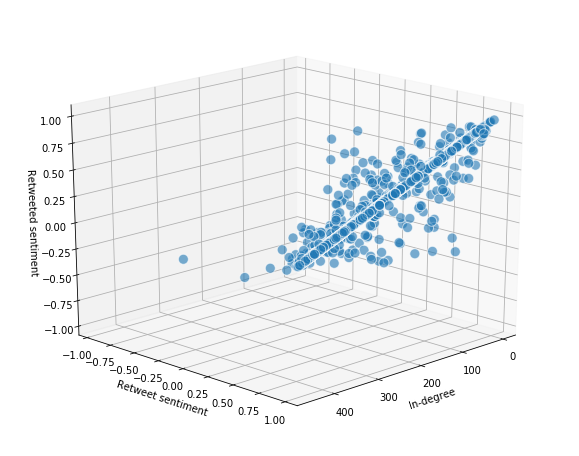

In [22]:
# Visualizando a correlação entre as variáveis

# Para a visualização 3D
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

z = df['target_sentiment']
x = df['degree']
y = df['source_sentiment']

ax.scatter3D(x, y, z, s=100, alpha=0.6, edgecolors='w')
ax.view_init(20, 45)

ax.set_xlabel('In-degree')
ax.set_ylabel('Retweet sentiment')
ax.set_zlabel('Retweeted sentiment')

Text(0,0.5,'Retweet sentiment')

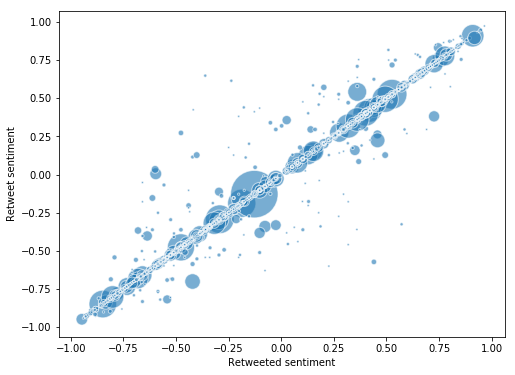

In [23]:
# Visualizando as variáveis através do gráfico de bolhas 
fig = plt.figure(figsize=(8, 6))
plt.scatter(df['target_sentiment'], df['source_sentiment'], s=df['degree']*5, alpha=0.6, edgecolors='w')
plt.xlabel('Retweeted sentiment')
plt.ylabel('Retweet sentiment')

## Referências bibliográficas

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.